<a href="https://colab.research.google.com/github/sheikmohdimran/Experiments_2021/blob/main/NLP/Cross_Encoder_SBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sentence-transformers -qqq

     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 2.6 MB 37.2 MB/s 
     |████████████████████████████████| 1.2 MB 54.7 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 3.3 MB 54.9 MB/s 
     |████████████████████████████████| 636 kB 75.7 MB/s 
     |████████████████████████████████| 895 kB 61.4 MB/s 


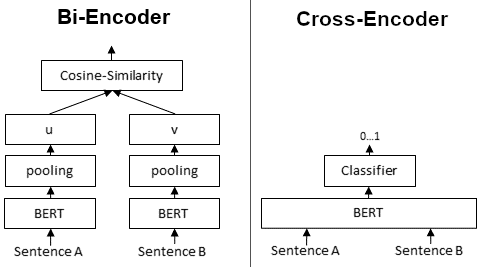

In [2]:
"""
This examples trains a CrossEncoder for the STSbenchmark task. A CrossEncoder takes a sentence pair
as input and outputs a label. Here, it output a continious labels 0...1 to indicate the similarity between the input pair.

It does NOT produce a sentence embedding and does NOT work for individual sentences.

Usage:
python training_stsbenchmark.py
"""
from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
from sentence_transformers import InputExample
import logging
from datetime import datetime
import sys
import os
import gzip
import csv

In [ ]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout



#Check if dataset exsist. If not, download and extract  it
sts_dataset_path = 'datasets/stsbenchmark.tsv.gz'

if not os.path.exists(sts_dataset_path):
    util.http_get('https://sbert.net/datasets/stsbenchmark.tsv.gz', sts_dataset_path)



#Define our Cross-Encoder
train_batch_size = 16
num_epochs = 4
model_save_path = 'output/training_stsbenchmark-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


In [21]:
#We use distilroberta-base as base model and set num_labels=1, which predicts a continous score between 0 and 1
model = CrossEncoder('microsoft/xtremedistil-l6-h256-uncased', num_labels=1, max_length=512)



# Read STSb dataset
logger.info("Read STSbenchmark train dataset")

train_samples = []
dev_samples = []
test_samples = []
with gzip.open(sts_dataset_path, 'rt', encoding='utf8') as fIn:
    reader = csv.DictReader(fIn, delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in reader:
        score = float(row['score']) / 5.0  # Normalize score to range 0 ... 1

        if row['split'] == 'dev':
            dev_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
        elif row['split'] == 'test':
            test_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
        else:
            #As we want to get symmetric scores, i.e. CrossEncoder(A,B) = CrossEncoder(B,A), we pass both combinations to the train set
            train_samples.append(InputExample(texts=[row['sentence1'], row['sentence2']], label=score))
            train_samples.append(InputExample(texts=[row['sentence2'], row['sentence1']], label=score))


# We wrap train_samples (which is a List[InputExample]) into a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)


# We add an evaluator, which evaluates the performance during training
evaluator = CECorrelationEvaluator.from_input_examples(dev_samples, name='sts-dev')


# Configure the training
warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/xtremedistil-l6-h256-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


2021-08-27 07:06:03 - Use pytorch device: cuda
2021-08-27 07:06:03 - Read STSbenchmark train dataset
2021-08-27 07:06:03 - Warmup-steps: 288


In [22]:
# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps,
          output_path=model_save_path)


##### Load model and eval on test set
model = CrossEncoder(model_save_path)

evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')
evaluator(model)

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

2021-08-27 07:06:28 - CECorrelationEvaluator: Evaluating the model on sts-dev dataset after epoch 0:
2021-08-27 07:06:28 - Correlation:	Pearson: 0.8848	Spearman: 0.8893
2021-08-27 07:06:28 - Save model to output/training_stsbenchmark-2021-08-27_05-59-32


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

2021-08-27 07:06:47 - CECorrelationEvaluator: Evaluating the model on sts-dev dataset after epoch 1:
2021-08-27 07:06:48 - Correlation:	Pearson: 0.8934	Spearman: 0.8948
2021-08-27 07:06:48 - Save model to output/training_stsbenchmark-2021-08-27_05-59-32


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

2021-08-27 07:07:07 - CECorrelationEvaluator: Evaluating the model on sts-dev dataset after epoch 2:
2021-08-27 07:07:07 - Correlation:	Pearson: 0.8959	Spearman: 0.8974
2021-08-27 07:07:07 - Save model to output/training_stsbenchmark-2021-08-27_05-59-32


Iteration:   0%|          | 0/719 [00:00<?, ?it/s]

2021-08-27 07:07:26 - CECorrelationEvaluator: Evaluating the model on sts-dev dataset after epoch 3:
2021-08-27 07:07:27 - Correlation:	Pearson: 0.8977	Spearman: 0.8981
2021-08-27 07:07:27 - Save model to output/training_stsbenchmark-2021-08-27_05-59-32


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


2021-08-27 07:07:27 - Use pytorch device: cuda
2021-08-27 07:07:27 - CECorrelationEvaluator: Evaluating the model on sts-test dataset:
2021-08-27 07:07:27 - Correlation:	Pearson: 0.8766	Spearman: 0.8694


0.8693643992721857